In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import scipy.stats
import matplotlib.pyplot as plt
import math
from matplotlib import ticker as mticker
originaldata=pd.read_csv('rawdata.csv')
originaldata

,Station1,Station2,Station3,Station4,Station5,Station6,Station7,Station8,Station9,Station10,Station11,Station12
0,2.449407,3.375368,3.262101,2.959110,6.716756,4.825191,10.550857,10.287510,12.258363,30.978630,38.595862,36.160613
1,1.189308,3.870913,2.976101,4.273012,5.445330,9.871253,10.757570,27.079400,35.311108,64.873896,78.522616,80.448161
2,8.427094,39.870120,48.874877,51.876463,56.888545,72.321226,75.860832,120.941252,183.294948,264.677565,263.063505,245.138941
3,37.321604,153.902061,225.175564,237.436759,377.180397,406.629917,206.288227,236.615570,226.563090,307.237786,294.212036,274.928264
4,15.528959,190.883863,240.778147,239.843691,342.350675,394.170505,652.136977,807.030128,853.469756,1169.485765,1117.665935,1114.834251
...,...,...,...,...,...,...,...,...,...,...,...,...
235,2.528694,5.244280,6.733746,6.861172,9.276599,4.986597,12.796383,6.419429,6.691271,24.327003,24.542211,11.978026
236,1.512120,3.131843,3.131843,3.471645,8.806539,2.072793,9.429510,14.486899,25.247300,82.656875,83.223212,73.425583
237,0.957109,2.248358,2.579665,4.165408,28.186589,28.373480,14.237710,157.838103,270.057766,476.572528,408.328928,379.445744
238,0.563505,0.710753,2.964774,3.567923,7.127350,10.369629,27.351242,71.301820,106.584611,410.594276,469.493317,481.103224


In [4]:
# Data quantization
from Info_theory_function_lists import km_global_quantization
from Info_theory_function_lists import km_local_quantization
from Info_theory_function_lists import eqdistant_global_quantization
from Info_theory_function_lists import eqdistant_local_quantization
from Info_theory_function_lists import floor_global_quantization

a_f=150 # 150(m^3/s) for  a_f parameter defined in the paper

# eq_global_quantized8 returns a series of bin numbers while eq_global_quantized8_values returns a series of quantized values (representing center of the bins that original data falls in)
eq_global_quantized8,eq_global_quantized8_values,NA,eq_global_edges8=eqdistant_global_quantization(originaldata,8)
eq_global_quantized14,eq_global_quantized14_values,NA,eq_global_edges14=eqdistant_global_quantization(originaldata,14)
km_global_quantized8,km_global_quantized8_values,NA,km_global_edges8=km_global_quantization(originaldata,8)
km_global_quantized14,km_global_quantized14_values,NA,km_global_edges14=km_global_quantization(originaldata,14)
floor_global_quantized14,floor_global_quantized14_values,NA,floor_global_edges14=floor_global_quantization(originaldata,a_f)

Station_list=originaldata.columns
eq_local_quantized8= pd.DataFrame(np.zeros(240*12, dtype='f').reshape(240,12),columns=Station_list)
km_local_quantized8= pd.DataFrame(np.zeros(240*12, dtype='f').reshape(240,12),columns=Station_list)
eq_local_quantized8_values= pd.DataFrame(np.zeros(240*12, dtype='f').reshape(240,12),columns=Station_list)
km_local_quantized8_values= pd.DataFrame(np.zeros(240*12, dtype='f').reshape(240,12),columns=Station_list)
eq_local_edges8= pd.DataFrame(np.zeros(9*12, dtype='f').reshape(9,12),columns=Station_list)
km_local_edges8= pd.DataFrame(np.zeros(9*12, dtype='f').reshape(9,12),columns=Station_list)
for Station in Station_list:
    eq_local_quantized8[Station],eq_local_quantized8_values[Station],NA,eq_local_edges8[Station]=eqdistant_local_quantization(originaldata[Station],8)
    km_local_quantized8[Station],km_local_quantized8_values[Station],NA,km_local_edges8[Station]=km_local_quantization(originaldata[Station],8)
    

In [5]:
def cont_entropy(densities,bin_edges):
    np.seterr(all="ignore")
    dens=densities.copy()
    bin_widths=np.diff(bin_edges)
    p_vec=bin_widths*dens
    #print(p_vec*np.log2(dens))
    #dens[p_vec==0]=99
    H_cont= -np.nansum(p_vec*np.log2(dens))
    return H_cont
def differential_entropy(data,bin_edges):
    x = data
    x=x.to_numpy()
    binx=bin_edges
    binx=np.squeeze(binx) # convert (n,1) to (n,)
    dens,bins= np.histogram(x,bins = binx,density=1)
    bin_widths=np.diff(bin_edges)
    p_vec=bin_widths*dens
    dens=dens[dens != 0] # delete zero element(log(0) would make problem)
    p_vec=p_vec[p_vec != 0] # delete zero element
    H_differential= -np.nansum(p_vec*np.log2(dens))
    return H_differential
differential_entropy(floor_global_quantized14_values.iloc[:,11],floor_global_edges14)

9.344523527718641

In [6]:
from Info_theory_function_lists import likelihood_calculator_quantized_data
from Info_theory_function_lists import entropy_1D

Table1_part1_suprise_score= pd.DataFrame(np.zeros(7*12, dtype='f').reshape(7,12),index=['floor14','km_global14','eq_global14','km_global8','eq_global8','km_local8','eq_local8',]
                  ,columns=['Station1','Station2','Station3','Station4','Station5','Station6','Station7','Station8','Station9','Station10','Station11','Station12',])
Table1_part2_differential_entropy=pd.DataFrame(np.zeros(7*12, dtype='f').reshape(7,12),index=['floor14','km_global14','eq_global14','km_global8','eq_global8','km_local8','eq_local8',]
                  ,columns=['Station1','Station2','Station3','Station4','Station5','Station6','Station7','Station8','Station9','Station10','Station11','Station12',])
Table1_part3_discrete_entropy=pd.DataFrame(np.zeros(7*12, dtype='f').reshape(7,12),index=['floor14','km_global14','eq_global14','km_global8','eq_global8','km_local8','eq_local8',]
                  ,columns=['Station1','Station2','Station3','Station4','Station5','Station6','Station7','Station8','Station9','Station10','Station11','Station12',])


for i in np.arange(12):
    Table1_part1_suprise_score.iloc[0,i]=likelihood_calculator_quantized_data(floor_global_quantized14_values.iloc[:,i],floor_global_edges14)
    Table1_part1_suprise_score.iloc[1,i]=likelihood_calculator_quantized_data(km_global_quantized14_values.iloc[:,i],km_global_edges14)
    Table1_part1_suprise_score.iloc[2,i]=likelihood_calculator_quantized_data(eq_global_quantized14_values.iloc[:,i],eq_global_edges14)
    Table1_part1_suprise_score.iloc[3,i]=likelihood_calculator_quantized_data(km_global_quantized8_values.iloc[:,i],km_global_edges8)
    Table1_part1_suprise_score.iloc[4,i]=likelihood_calculator_quantized_data(eq_global_quantized8_values.iloc[:,i],eq_global_edges8)
    Table1_part1_suprise_score.iloc[5,i]=likelihood_calculator_quantized_data(km_local_quantized8_values.iloc[:,i],km_local_edges8.iloc[:,i])
    Table1_part1_suprise_score.iloc[6,i]=likelihood_calculator_quantized_data(eq_local_quantized8_values.iloc[:,i],eq_local_edges8.iloc[:,i])
    
for i in np.arange(12):
    Table1_part2_differential_entropy.iloc[0,i]=differential_entropy(floor_global_quantized14_values.iloc[:,i],floor_global_edges14)
    Table1_part2_differential_entropy.iloc[1,i]=differential_entropy(km_global_quantized14_values.iloc[:,i],km_global_edges14)
    Table1_part2_differential_entropy.iloc[2,i]=differential_entropy(eq_global_quantized14_values.iloc[:,i],eq_global_edges14)
    Table1_part2_differential_entropy.iloc[3,i]=differential_entropy(km_global_quantized8_values.iloc[:,i],km_global_edges8)
    Table1_part2_differential_entropy.iloc[4,i]=differential_entropy(eq_global_quantized8_values.iloc[:,i],eq_global_edges8)
    Table1_part2_differential_entropy.iloc[5,i]=differential_entropy(km_local_quantized8_values.iloc[:,i],km_local_edges8.iloc[:,i])
    Table1_part2_differential_entropy.iloc[6,i]=differential_entropy(eq_local_quantized8_values.iloc[:,i],eq_local_edges8.iloc[:,i])
for i in np.arange(12):
    Table1_part3_discrete_entropy.iloc[0,i]=entropy_1D(floor_global_quantized14_values.iloc[:,i])
    Table1_part3_discrete_entropy.iloc[1,i]=entropy_1D(km_global_quantized14_values.iloc[:,i])
    Table1_part3_discrete_entropy.iloc[2,i]=entropy_1D(eq_global_quantized14_values.iloc[:,i])
    Table1_part3_discrete_entropy.iloc[3,i]=entropy_1D(km_global_quantized8_values.iloc[:,i])
    Table1_part3_discrete_entropy.iloc[4,i]=entropy_1D(eq_global_quantized8_values.iloc[:,i])
    Table1_part3_discrete_entropy.iloc[5,i]=entropy_1D(km_local_quantized8_values.iloc[:,i])
    Table1_part3_discrete_entropy.iloc[6,i]=entropy_1D(eq_local_quantized8_values.iloc[:,i])
    
pd.options.display.float_format = "{:,.1f}".format
display('======================================Table1_part1: Comparison of data representativeness with Surprise score ==================================')
display(Table1_part1_suprise_score)
display('======================================Table1_part2: Comparison of data representativeness with Differential entropy =====================')
pd.options.display.float_format = "{:,.2f}".format
display(Table1_part2_differential_entropy)
display('======================================Table1_part3: Comparison of data representativeness with Discrete entropy =====================')
pd.options.display.float_format = "{:,.2f}".format
display(Table1_part3_discrete_entropy)

'======================================Table1_part1: Comparison of data representativeness with Surprise score =================================='

,Station1,Station2,Station3,Station4,Station5,Station6,Station7,Station8,Station9,Station10,Station11,Station12
floor14,"1,054.4","1,101.3","1,103.8","1,115.1","1,148.2","1,161.0","1,182.0","1,253.9","1,307.5","1,530.0","1,548.6","1,554.5"
km_global14,798.8,926.0,897.4,951.5,986.0,"1,022.2","1,102.0","1,228.2","1,288.7","1,519.1","1,537.2","1,550.8"
eq_global14,"1,190.6","1,225.7","1,222.2","1,229.0","1,238.9","1,242.8","1,274.1","1,315.0","1,355.7","1,542.2","1,556.5","1,564.1"
km_global8,952.5,"1,034.4","1,030.0","1,035.3","1,069.7","1,086.6","1,139.6","1,236.8","1,296.7","1,539.7","1,550.0","1,565.7"
eq_global8,"1,324.9","1,331.4","1,324.9","1,331.4","1,349.2","1,356.6","1,369.0","1,390.8","1,411.5","1,570.9","1,577.5","1,579.6"
km_local8,667.5,903.5,860.9,900.4,958.8,"1,003.1","1,096.6","1,218.9","1,283.5","1,520.8","1,534.2","1,553.2"
eq_local8,756.2,989.9,959.3,980.2,"1,064.3","1,097.0","1,187.2","1,283.5","1,323.7","1,549.5","1,555.1","1,578.8"


'======================================Table1_part2: Comparison of data representativeness with Differential entropy ====================='

,Station1,Station2,Station3,Station4,Station5,Station6,Station7,Station8,Station9,Station10,Station11,Station12
floor14,6.34,6.62,6.64,6.70,6.90,6.98,7.11,7.54,7.86,9.20,9.31,9.34
km_global14,4.80,5.57,5.39,5.72,5.93,6.14,6.62,7.38,7.75,9.13,9.24,9.32
eq_global14,7.16,7.37,7.35,7.39,7.45,7.47,7.66,7.90,8.15,9.27,9.36,9.40
km_global8,5.73,6.22,6.19,6.22,6.43,6.53,6.85,7.43,7.79,9.26,9.32,9.41
eq_global8,7.96,8.00,7.96,8.00,8.11,8.15,8.23,8.36,8.48,9.44,9.48,9.50
km_local8,4.01,5.43,5.18,5.41,5.76,6.03,6.59,7.33,7.72,9.14,9.22,9.34
eq_local8,4.55,5.95,5.77,5.89,6.40,6.59,7.14,7.72,7.96,9.31,9.35,9.49


'======================================Table1_part3: Comparison of data representativeness with Discrete entropy ====================='

,Station1,Station2,Station3,Station4,Station5,Station6,Station7,Station8,Station9,Station10,Station11,Station12
floor14,0.10,0.34,0.35,0.41,0.57,0.64,0.74,1.09,1.33,2.39,2.45,2.47
km_global14,0.57,1.15,1.02,1.26,1.41,1.56,1.88,2.33,2.50,3.15,3.23,3.31
eq_global14,0.00,0.21,0.19,0.23,0.29,0.31,0.50,0.75,0.99,2.11,2.20,2.25
km_global8,0.15,0.54,0.52,0.55,0.71,0.79,1.03,1.44,1.68,2.50,2.54,2.58
eq_global8,0.00,0.04,0.00,0.04,0.15,0.19,0.27,0.40,0.52,1.48,1.52,1.53
km_local8,2.12,1.71,1.68,1.70,1.79,1.75,1.80,1.69,1.86,2.24,2.26,2.28
eq_local8,0.91,0.96,0.83,0.89,0.84,0.87,0.79,1.06,1.14,1.64,1.60,1.53


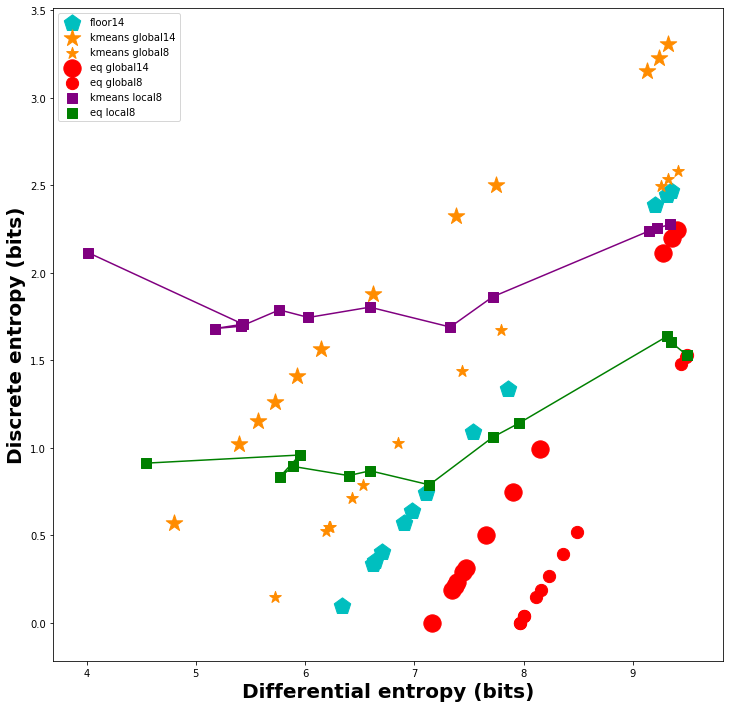

In [109]:
fig=plt.figure(figsize=(12, 12))
plt.scatter(Table1_part2_differential_entropy.iloc[0,:], Table1_part3_discrete_entropy.iloc[0,:],c='c',s=300,marker="p",label ='floor14')
plt.scatter(Table1_part2_differential_entropy.iloc[1,:], Table1_part3_discrete_entropy.iloc[1,:],c='darkorange',s=300,marker="*",label ='kmeans global14')
plt.scatter(Table1_part2_differential_entropy.iloc[3,:], Table1_part3_discrete_entropy.iloc[3,:],c='darkorange',s=150,marker="*",label ='kmeans global8')
plt.scatter(Table1_part2_differential_entropy.iloc[2,:], Table1_part3_discrete_entropy.iloc[2,:],c='r',s=300,marker="o",label ='eq global14')
plt.scatter(Table1_part2_differential_entropy.iloc[4,:], Table1_part3_discrete_entropy.iloc[4,:],c='r',s=150,marker="o",label ='eq global8')

plt.scatter(Table1_part2_differential_entropy.iloc[5,:], Table1_part3_discrete_entropy.iloc[5,:], c='purple',s=100,marker="s",  label ='kmeans local8')
plt.plot(Table1_part2_differential_entropy.iloc[5,:], Table1_part3_discrete_entropy.iloc[5,:],color='purple')
plt.scatter(Table1_part2_differential_entropy.iloc[6,:], Table1_part3_discrete_entropy.iloc[6,:],c='g',s=100,marker="s",label ='eq local8')
plt.plot(Table1_part2_differential_entropy.iloc[6,:], Table1_part3_discrete_entropy.iloc[6,:],color='g')

plt.legend(loc='upper left')
plt.ylabel("Discrete entropy (bits)",fontsize=20,fontweight="bold")
plt.xlabel("Differential entropy (bits)",fontsize=20,fontweight="bold")
plt.show()
fig.savefig("Differential entropy",dpi=500, bbox_inches="tight", pad_inches=.5,transparent=True)